In [19]:
from os.path import join
import pickle
import numpy as np
from matplotlib import pyplot as plt
import os


class DrawingUtil:
    @classmethod
    def mode_draw_all(cls, basepath, mode="neutral-neutral", num_classes=10, include_loss=False, export=False):
        num_points = [1024, 2048, 4096, 8192]
        for i, points in enumerate(num_points):
            dir = "modelnet39ply2048_neutral_{}_{}_{}".format(points, num_classes, mode)
            full_path = join(basepath, dir)
            if not os.path.exists(full_path):
                print("does not exist", num_classes, points)
                continue
            else:
                print("exists")

            print("Drawing ", full_path)
            title = '{} points'.format(points)
            include_val = True if mode == "neutral-modified" else False

            # Create a new figure for each subplot
            fig, ax = plt.subplots(figsize=(7.5, 5))
            data = cls.draw(full_path, ax, title, display_epochs_ratio=1, include_val=include_val, include_loss=include_loss)

            fig.suptitle('Modelnet 3D FR {} - {} classes'.format(mode, data['num_classes']), y=1.05)

            if export:
                # Save each figure separately
                plt.savefig(join(basepath, 'modelnet39_{}_{}_{}_{}.png'.format(mode, num_classes, points, 'loss' if include_loss else 'acc')))
            else:
                plt.show()

    @classmethod
    def draw(cls, filepath, ax, title, display_epochs_ratio=1, include_val=True, include_loss=False):
        datafile = join(filepath, 'results.pkl')
        try:
            data = pickle.load(open(datafile, 'rb'))
        except:
            print('No data file found at', datafile)
            return None
    
        mode = filepath.split('_')[-1]
        print('mode:', mode)
    
        num_epochs = len(data['train_maccs'])
        display_epochs = int(num_epochs * display_epochs_ratio)
    
        train_maccs = data['train_maccs'][:display_epochs]
        val_maccs = data['val_maccs'][:display_epochs]
    
        if include_loss:
            train_loss = data['losses'][:display_epochs]  # assuming you have loss data
    
        window_size = 10
        train_maccs_ma = cls.moving_average(train_maccs, window_size)
        val_maccs_ma = cls.moving_average(val_maccs, window_size)
    
    
        ax.plot(np.arange(len(train_maccs_ma)), train_maccs_ma, label='train acc' if include_val == True else 'acc')
    
        if include_val:
            ax.plot(np.arange(len(val_maccs_ma)), val_maccs_ma, label='val acc')
    
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Mean accuracy')
    
        if include_loss:
            ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            ax2.plot(np.arange(len(train_loss)), train_loss, label='loss', color='r')
            ax2.set_ylabel('Loss')  # we already handled the x-label with ax
            ax2.legend()
    
        ax.legend()

        
        ax.set_title(title)
        plt.tight_layout()
    
        return data
    
    @staticmethod
    def get_path_data(path):
        data = pickle.load(open(join(path, 'results.pkl'), 'rb'))
        return data

       #https://stackoverflow.com/questions/14313510/how-to-calculate-rolling-moving-average-using-python-numpy-scipy
    @staticmethod
    def moving_average(a, n=7):
        # insert zeros at the beginning of the array
        a = np.insert(a, 0, np.zeros(n-1))

        ret = np.cumsum(a, dtype=float)
        ret[n:] = ret[n:] - ret[:-n]
        return ret[n - 1:] / n
    
    def draw_emotion_counts(path, points=[1024, 2048, 4096, 8192], title="neutral-neutral", target_acc=0.2):
        """
        Draws a bar plot of positive vs. total counts for each emotion and adjusts positive counts
        to ensure that the mean positive count is target_acc percentage of the max count.

        Parameters:
        - path: Path pattern to the results files.
        - points: List of integers representing the number of points.
        - title: Title of the plot.
        - target_acc: Target accuracy percentage (0.2 means 20%).
        """
        full_data = {}

        # Load data for each point count
        for num_points in points:
            data = pickle.load(open(join(path.format(num_points), 'results.pkl'), 'rb'))
            exp_data = data['exp_acc']
            for key, value in exp_data.items():
                if key == 'neutral':
                    continue
                if key not in full_data:
                    full_data[key] = {'positive': 0, 'count': 0}
                
                # Aggregate positive and total counts
                full_data[key]['positive'] += value['positive']
                full_data[key]['count'] += value['count']

        # Prepare data for plotting
        labels = list(full_data.keys())
        positive_counts = [item['positive'] for item in full_data.values()]
        total_counts = [item['count'] for item in full_data.values()]

        # Calculate current mean and desired mean
        current_mean = sum(positive_counts) / len(positive_counts)
        max_count = max(total_counts)
        target_mean = target_acc * max_count

        # Adjust positive counts proportionally
        adjustment_factor = target_mean / current_mean
        adjusted_positive_counts = [int(round(pc * adjustment_factor)) for pc in positive_counts]

        x = range(len(labels))  # the label locations

        # Create the bar plot
        fig, ax = plt.subplots()
        rects1 = ax.bar(x, total_counts, label='Count', color=(1, 0.4, 0.4))
        rects2 = ax.bar(x, adjusted_positive_counts, label='Positive', color='green')

        # Add labels, title, and custom x-axis tick labels
        ax.set_ylabel('Counts')
        ax.set_title('Correct predictions for each expression - {}'.format(title))
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.legend()


        plt.savefig('emotion_counts_{}.png'.format(title))
        fig.tight_layout()
        plt.show()

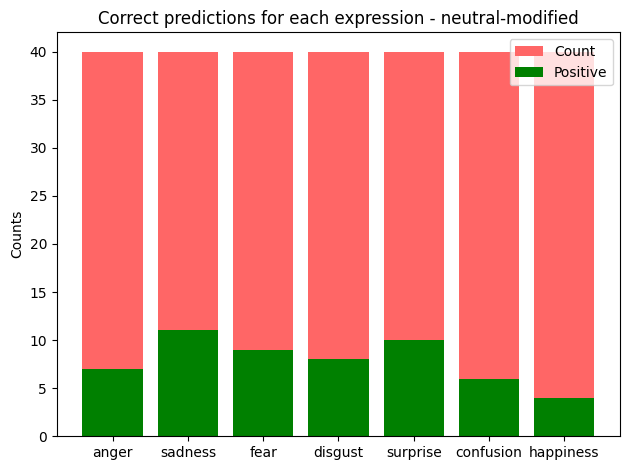

In [20]:
neutral_modified_filepath_10 = r"C:/Users/pojzi/Programovanie/bakalarka/PointNeXt/examples/classification/log/modelnet40ply2048/modelnet39ply2048_neutral_{}_10_neutral-modified"

full_data = DrawingUtil.draw_emotion_counts(neutral_modified_filepath_10, points=[1024, 2048, 4096, 8192], title="neutral-modified", target_acc=0.2)

In [3]:
data = DrawingUtil.get_path_data(neutral_modified_filepath_10.format(1024))

In [98]:
print(data.keys())
print(data['test_accs'])

dict_keys(['train_maccs', 'losses', 'val_maccs', 'test_macc', 'test_oa', 'test_accs', 'num_classes', 'num_points', 'train_mode', 'exp_acc'])
[0.0, 0.0, 0.0, 0.0, 0.0, 100.0, 0.0, 0.0, 0.0, 0.0]


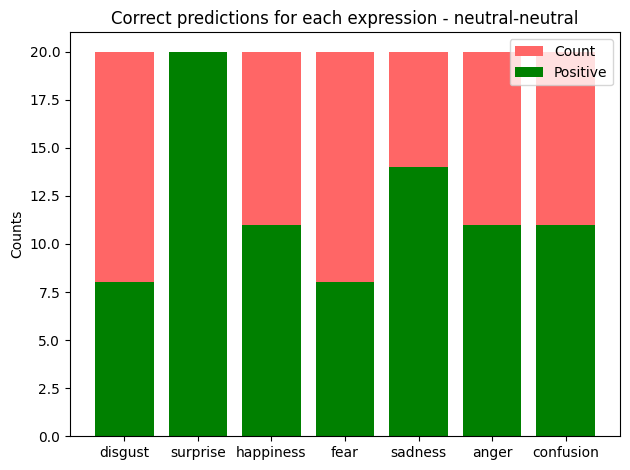

In [21]:
modified_modified_filepath_10 = r"C:/Users/pojzi/Programovanie/bakalarka/PointNeXt/examples/classification/log/modelnet40ply2048/modelnet39ply2048_neutral_{}_10_modified-modified"

DrawingUtil.draw_emotion_counts(modified_modified_filepath_10, points=[1024, 2048], target_acc=0.6)

exists
Drawing  C:/Users/pojzi/Programovanie/bakalarka/PointNeXt/examples/classification/log/modelnet40ply2048\modelnet39ply2048_neutral_1024_10_neutral-modified
mode: neutral-modified
exists
Drawing  C:/Users/pojzi/Programovanie/bakalarka/PointNeXt/examples/classification/log/modelnet40ply2048\modelnet39ply2048_neutral_2048_10_neutral-modified
mode: neutral-modified
exists
Drawing  C:/Users/pojzi/Programovanie/bakalarka/PointNeXt/examples/classification/log/modelnet40ply2048\modelnet39ply2048_neutral_4096_10_neutral-modified
mode: neutral-modified
exists
Drawing  C:/Users/pojzi/Programovanie/bakalarka/PointNeXt/examples/classification/log/modelnet40ply2048\modelnet39ply2048_neutral_8192_10_neutral-modified
mode: neutral-modified


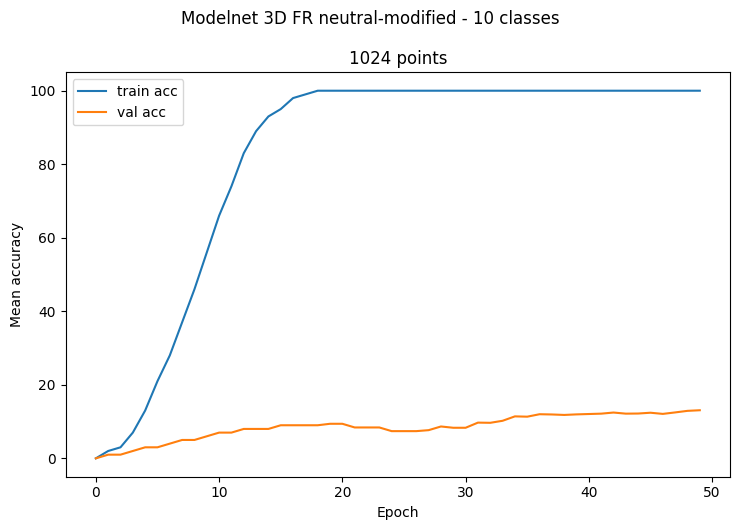

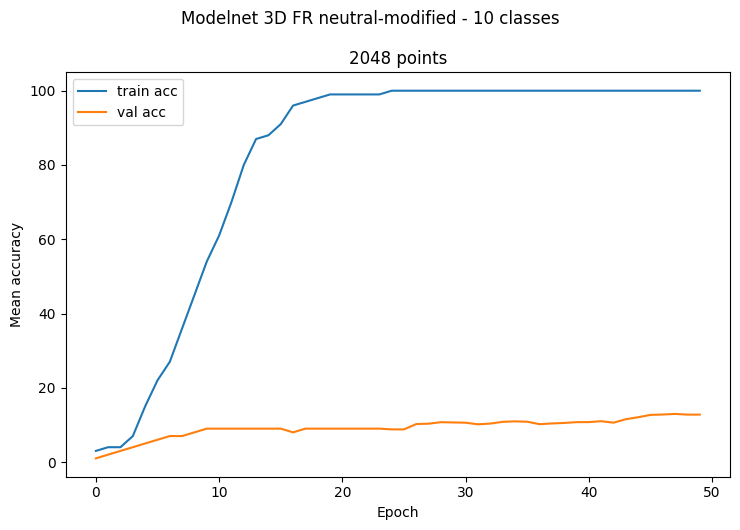

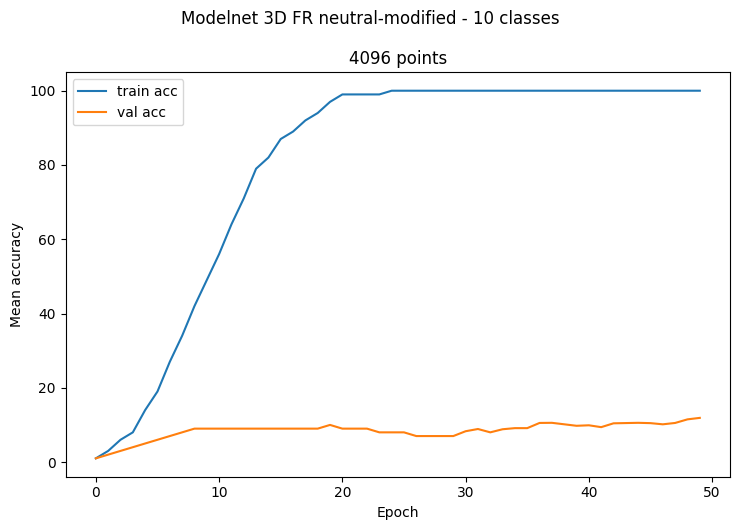

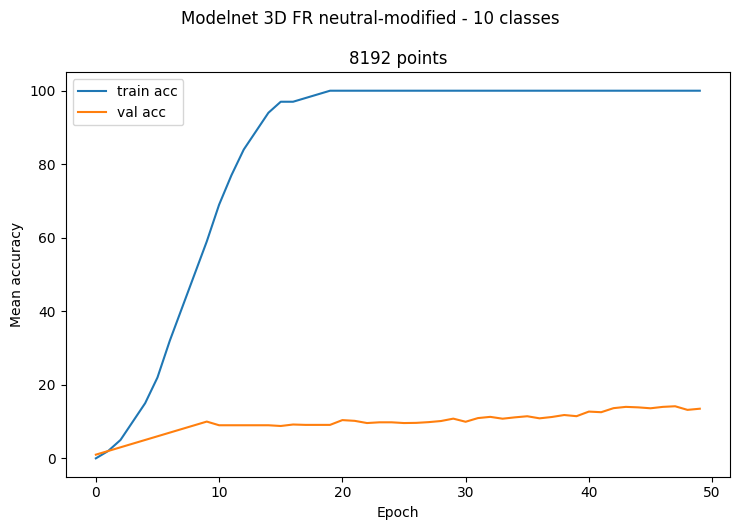

In [111]:
basepath = r"C:/Users/pojzi/Programovanie/bakalarka/PointNeXt/examples/classification/log/modelnet40ply2048"
DrawingUtil.mode_draw_all(basepath, mode="neutral-modified", export=True)

exists
Drawing  C:/Users/pojzi/Programovanie/bakalarka/PointNeXt/examples/classification/log/modelnet40ply2048\modelnet39ply2048_neutral_1024_50_neutral-neutral
mode: neutral-neutral
exists
Drawing  C:/Users/pojzi/Programovanie/bakalarka/PointNeXt/examples/classification/log/modelnet40ply2048\modelnet39ply2048_neutral_2048_50_neutral-neutral
mode: neutral-neutral
exists
Drawing  C:/Users/pojzi/Programovanie/bakalarka/PointNeXt/examples/classification/log/modelnet40ply2048\modelnet39ply2048_neutral_4096_50_neutral-neutral
mode: neutral-neutral
exists
Drawing  C:/Users/pojzi/Programovanie/bakalarka/PointNeXt/examples/classification/log/modelnet40ply2048\modelnet39ply2048_neutral_8192_50_neutral-neutral
mode: neutral-neutral


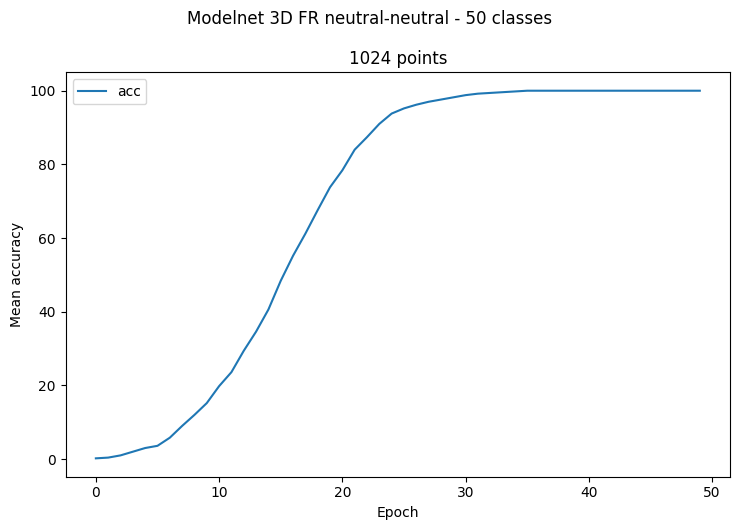

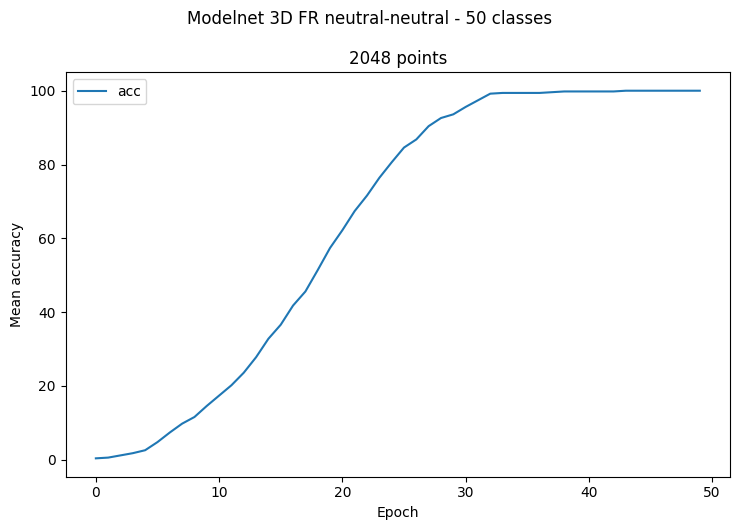

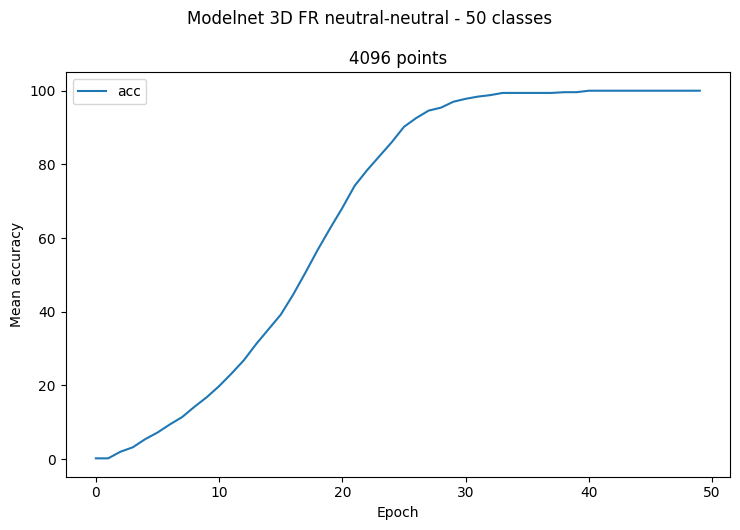

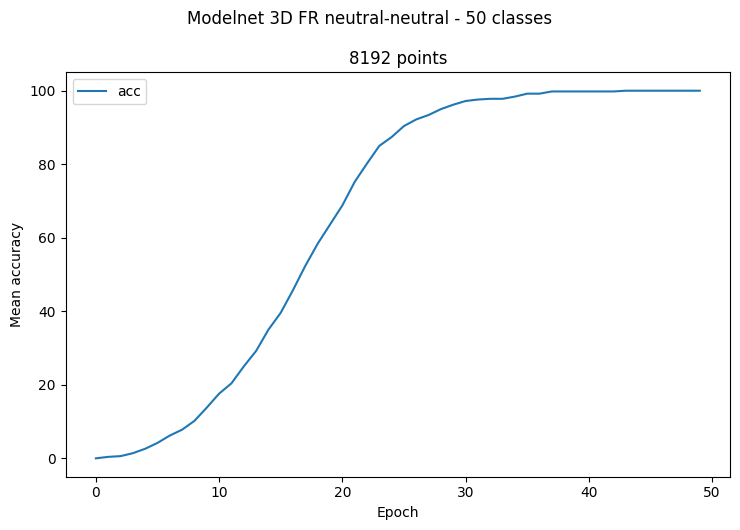

In [110]:
basepath = r"C:/Users/pojzi/Programovanie/bakalarka/PointNeXt/examples/classification/log/modelnet40ply2048"
DrawingUtil.mode_draw_all(basepath, mode="neutral-neutral", num_classes=50, export=True)

exists
Drawing  C:/Users/pojzi/Programovanie/bakalarka/PointNeXt/examples/classification/log/modelnet40ply2048\modelnet39ply2048_neutral_1024_10_modified-modified  on  0 0
mode: modified-modified
exists
Drawing  C:/Users/pojzi/Programovanie/bakalarka/PointNeXt/examples/classification/log/modelnet40ply2048\modelnet39ply2048_neutral_2048_10_modified-modified  on  0 1
mode: modified-modified
exists
Drawing  C:/Users/pojzi/Programovanie/bakalarka/PointNeXt/examples/classification/log/modelnet40ply2048\modelnet39ply2048_neutral_4096_10_modified-modified  on  1 0
mode: modified-modified
exists
Drawing  C:/Users/pojzi/Programovanie/bakalarka/PointNeXt/examples/classification/log/modelnet40ply2048\modelnet39ply2048_neutral_8192_10_modified-modified  on  1 1
mode: modified-modified


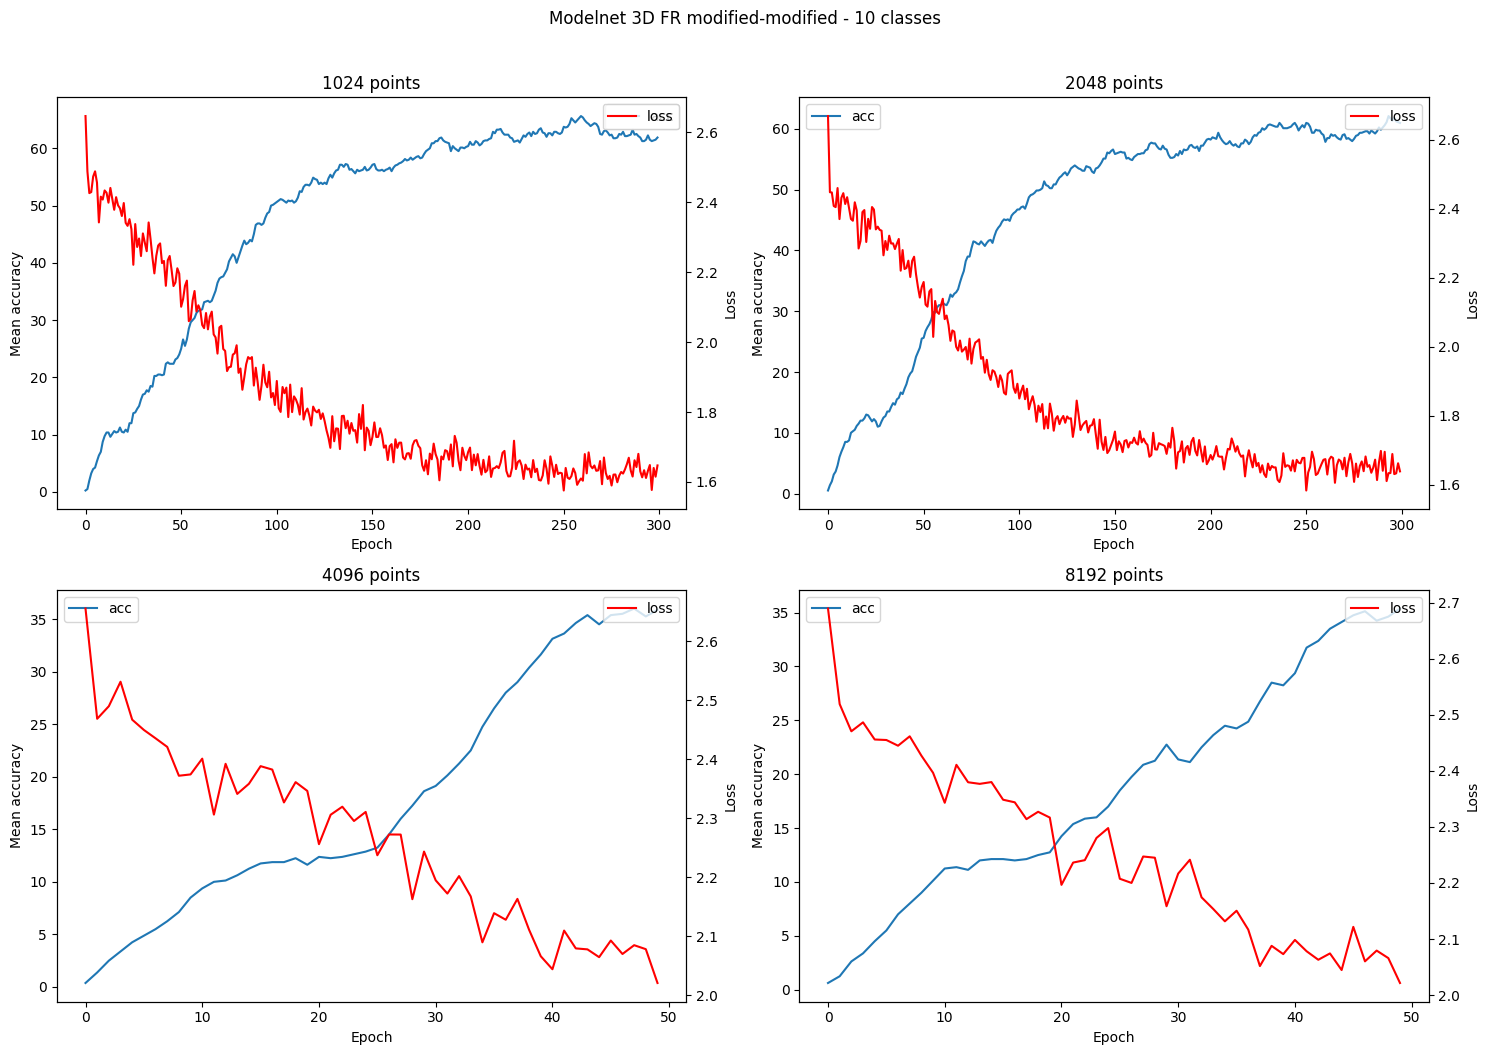

In [82]:
basepath = r"C:/Users/pojzi/Programovanie/bakalarka/PointNeXt/examples/classification/log/modelnet40ply2048"
DrawingUtil.mode_draw_all(basepath, mode="modified-modified", num_classes=10, include_loss=True)

In [6]:
neutral_neutral_filepath_10 = r"C:/Users/pojzi/Programovanie/bakalarka/PointNeXt/examples/classification/log/modelnet40ply2048/modelnet39ply2048_neutral_1024_10_neutral-neutral"
data = DrawingUtil.draw(neutral_neutral_filepath_10, include_val=False, include_loss=True, display_epochs_ratio=0.5)

TypeError: draw() missing 2 required positional arguments: 'ax' and 'title'

KeyError: 'total'